# Imports

In [1]:
!pip install river==0.16
import yfinance as yf
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


from river import metrics
from river import preprocessing
from river import linear_model
from river import tree
from river import forest
from river.neighbors import KNNRegressor


# Data Engineering

In [2]:
# Setting the stocks to predict
stock_symbols = ['GOOGL', 'META', 'AMZN']
stock_ds = [f'dataset_{stock_symbol}.csv' for stock_symbol in stock_symbols]

# Fetching stock data
google = pd.read_csv(stock_ds[0], index_col='timestamp', parse_dates=True)
facebook = pd.read_csv(stock_ds[1], index_col='timestamp', parse_dates=True)
amazon = pd.read_csv(stock_ds[2], index_col='timestamp', parse_dates=True)

# Preprocessing the data (example: using closing prices)
data = pd.DataFrame({
    'Google': google['price'],
    'Facebook': facebook['price'],
    'Amazon': amazon['price'],
    'SP500': google['sp500'],
    'CAC40': google['cac40'],
    'Nikkei': google['nikkei'],
}).dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
data.dropna(inplace = True)
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei
Date,,,,,,
2021-01-13,87.362503,251.639999,158.294495,3809.840088,5662.669922,28456.589844
2021-01-14,86.545998,245.639999,156.373505,3795.540039,5681.140137,28698.259766
2021-01-15,86.380997,251.360001,155.212494,3768.250000,5611.689941,28519.179688
2021-01-19,89.223503,261.100006,156.037994,3798.909912,5598.609863,28633.460938
2021-01-20,94.003502,267.480011,163.169006,3851.850098,5628.439941,28523.259766
...,...,...,...,...,...,...
2024-01-05,135.729996,351.950012,145.240005,4697.240234,7420.689941,33377.421875
2024-01-09,140.949997,357.429993,151.369995,4756.500000,7426.620117,33763.179688
2024-01-10,142.279999,370.470001,153.729996,4783.450195,7426.080078,34441.718750


#### Feature engineering

In [4]:
def calculate_technical_indicators(data, companies=['Google', 'Amazon', 'Facebook']):
    """
    Calculate RSI and Moving Averages (SMA and EMA) for specified companies.
    """
    # Calculate RSI
    window_length_rsi = 14
    for company in companies:
        delta = data[company].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(window_length_rsi).mean()
        roll_down = down.rolling(window_length_rsi).mean()
        RS = roll_up / roll_down
        data[f'{company}_RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate Moving Averages
    sma_ema_windows = [5, 10, 20]
    for company in companies:
        for window in sma_ema_windows:
            data[f'{company}_SMA_{window}'] = data[company].rolling(window=window).mean()
            data[f'{company}_EMA_{window}'] = data[company].ewm(span=window, adjust=False).mean()

    return data

updated_data = calculate_technical_indicators(data)

updated_data.dropna(inplace= True)


In [5]:
data = updated_data
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei,Google_RSI,Amazon_RSI,Facebook_RSI,Google_SMA_5,...,Amazon_SMA_10,Amazon_EMA_10,Amazon_SMA_20,Amazon_EMA_20,Facebook_SMA_5,Facebook_EMA_5,Facebook_SMA_10,Facebook_EMA_10,Facebook_SMA_20,Facebook_EMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-10,104.323997,271.869995,164.328995,3909.879883,5670.799805,29562.929688,71.551520,48.056659,49.013029,103.888499,...,165.384499,165.138110,163.276449,163.750090,268.497998,269.056015,266.155997,267.843380,265.9175,265.287122
2021-02-12,104.751503,270.500000,163.885498,3934.830078,5703.669922,29520.070312,71.560006,48.601808,46.031748,104.302499,...,165.584949,164.910362,163.555999,163.762986,269.300000,269.537343,266.705997,268.326402,266.8605,265.783587
2021-02-16,105.535004,273.970001,163.447495,3932.590088,5786.529785,30467.750000,72.380563,47.619860,45.988873,104.521201,...,165.898698,164.644386,163.909698,163.732939,270.473999,271.014896,268.269998,269.352511,268.2770,266.563245
2021-02-17,105.931000,273.570007,165.432007,3931.330078,5765.839844,30292.189453,72.048140,48.361724,40.924685,104.862201,...,165.727499,164.787590,164.420674,163.894755,271.872003,271.866600,269.425998,270.119328,269.3875,267.230556
2021-02-18,105.290497,269.390015,166.411499,3913.969971,5728.330078,30236.089844,85.720317,60.400578,46.645527,105.166400,...,165.468649,165.082846,164.939349,164.134445,271.860004,271.041071,269.657001,269.986726,269.8020,267.436219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05,135.729996,351.950012,145.240005,4697.240234,7420.689941,33377.421875,57.279239,48.684757,73.910748,138.481998,...,151.571001,149.622750,149.292500,148.975416,353.835999,351.846309,352.091998,349.577130,339.9175,343.827267
2024-01-09,140.949997,357.429993,151.369995,4756.500000,7426.620117,33763.179688,69.872664,56.649568,72.185082,138.597998,...,151.300999,149.940431,149.619000,149.203471,353.756000,353.707537,353.372998,351.004923,341.7880,345.122764
2024-01-10,142.279999,370.470001,153.729996,4783.450195,7426.080078,34441.718750,71.587333,58.082640,77.556727,139.007999,...,151.295000,150.629442,149.961500,149.634568,356.185999,359.295025,355.384000,354.544028,344.3970,347.536787


# Batch Models

### Linear Regression

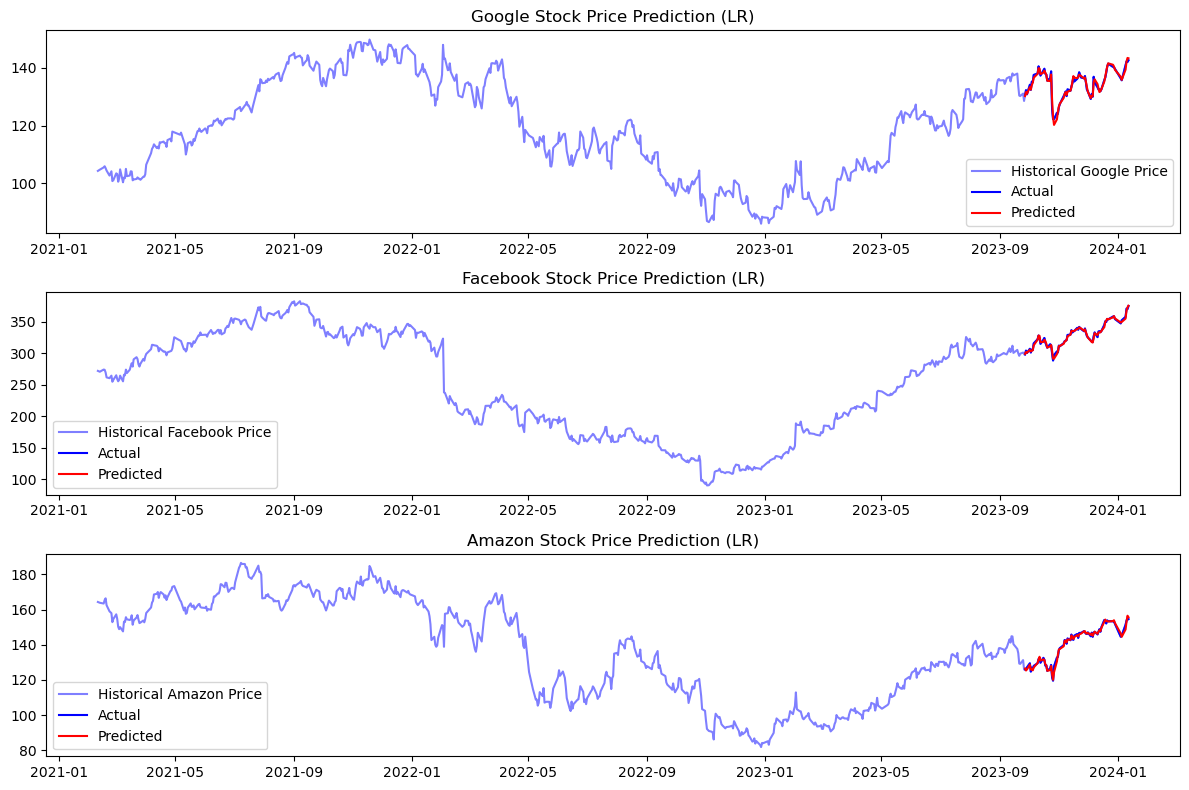

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,0.625448,0.997825,0.701118,0.969052
1,Facebook,5.604422,0.999127,3.894272,0.989505
2,Amazon,1.143082,0.998604,0.868021,0.991348


In [6]:
def create_and_evaluate_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Model training
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))

# Google
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Google'], label=f'Historical Google Price', color='blue', alpha=0.5)
plt.plot(google_y_test.index, google_y_test, label='Actual', color='blue')
plt.plot(google_y_test.index, google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (LR)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Facebook'], label=f'Historical Facebook Price', color='blue', alpha=0.5)
plt.plot(facebook_y_test.index, facebook_y_test, label='Actual', color='blue')
plt.plot(facebook_y_test.index, facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (LR)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Amazon'], label=f'Historical Amazon Price', color='blue', alpha=0.5)
plt.plot(amazon_y_test.index, amazon_y_test, label='Actual', color='blue')
plt.plot(amazon_y_test.index, amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (LR)')
plt.legend()

plt.tight_layout()
plt.show()


results_df

## XGboost

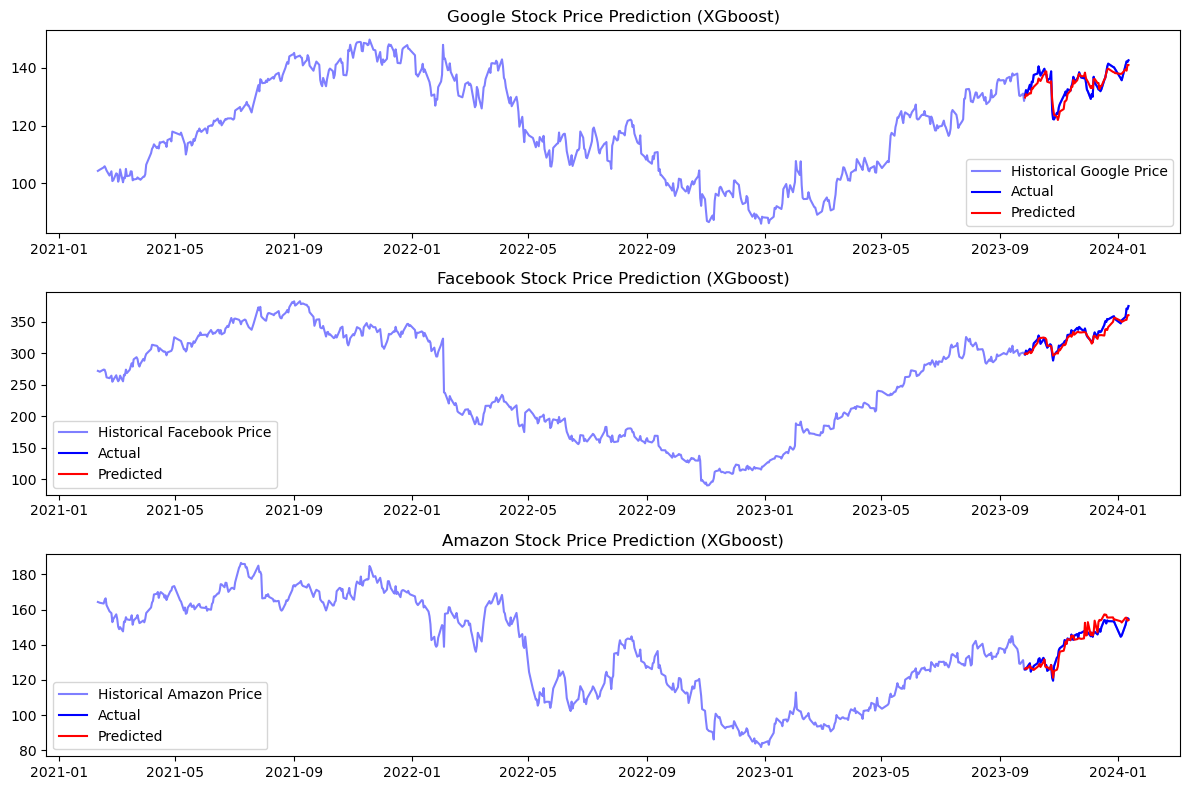

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,0.002305,0.999992,4.540237,0.799590
1,Facebook,0.029398,0.999995,43.230925,0.883498
2,Amazon,0.006384,0.999992,10.181047,0.898526


In [7]:
def create_and_evaluate_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Model training (using XGBoost)
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))

# Google
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Google'], label=f'Historical Google Price', color='blue', alpha=0.5)
plt.plot(google_y_test.index, google_y_test, label='Actual', color='blue')
plt.plot(google_y_test.index, google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (XGboost)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Facebook'], label=f'Historical Facebook Price', color='blue', alpha=0.5)
plt.plot(facebook_y_test.index, facebook_y_test, label='Actual', color='blue')
plt.plot(facebook_y_test.index, facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (XGboost)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Amazon'], label=f'Historical Amazon Price', color='blue', alpha=0.5)
plt.plot(amazon_y_test.index, amazon_y_test, label='Actual', color='blue')
plt.plot(amazon_y_test.index, amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (XGboost)')
plt.legend()

plt.tight_layout()
plt.show()

results_df


## LSTM

Epoch 1/50
20/20 [==============================] - 1s 1ms/step - loss: 0.2080
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 6/50
20/20 [==============================] - 0s 838us/step - loss: 0.0051
Epoch 7/50
20/20 [==============================] - 0s 882us/step - loss: 0.0042
Epoch 8/50
20/20 [==============================] - 0s 861us/step - loss: 0.0035
Epoch 9/50
20/20 [==============================] - 0s 845us/step - loss: 0.0030
Epoch 10/50
20/20 [==============================] - 0s 896us/step - loss: 0.0027
Epoch 11/50
20/20 [==============================] - 0s 876us/step - loss: 0.0024
Epoch 12/50
20/20 [==============================] - 0s 853us/step - loss: 0.0022
Epoch 13/50
20/20 [================

Epoch 1/50
20/20 [==============================] - 1s 1ms/step - loss: 0.2401
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0421
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 5/50
20/20 [==============================] - 0s 992us/step - loss: 0.0062
Epoch 6/50
20/20 [==============================] - 0s 863us/step - loss: 0.0048
Epoch 7/50
20/20 [==============================] - 0s 855us/step - loss: 0.0036
Epoch 8/50
20/20 [==============================] - 0s 858us/step - loss: 0.0027
Epoch 9/50
20/20 [==============================] - 0s 869us/step - loss: 0.0021
Epoch 10/50
20/20 [==============================] - 0s 878us/step - loss: 0.0016
Epoch 11/50
20/20 [==============================] - 0s 887us/step - loss: 0.0013
Epoch 12/50
20/20 [==============================] - 0s 862us/step - loss: 0.0011
Epoch 13/50
20/20 [==============

Epoch 1/50
20/20 [==============================] - 1s 1ms/step - loss: 0.1356
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0143
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 5/50
20/20 [==============================] - 0s 957us/step - loss: 0.0041
Epoch 6/50
20/20 [==============================] - 0s 882us/step - loss: 0.0029
Epoch 7/50
20/20 [==============================] - 0s 870us/step - loss: 0.0022
Epoch 8/50
20/20 [==============================] - 0s 864us/step - loss: 0.0018
Epoch 9/50
20/20 [==============================] - 0s 837us/step - loss: 0.0015
Epoch 10/50
20/20 [==============================] - 0s 858us/step - loss: 0.0014
Epoch 11/50
20/20 [==============================] - 0s 878us/step - loss: 0.0014
Epoch 12/50
20/20 [==============================] - 0s 891us/step - loss: 0.0013
Epoch 13/50
20/20 [==============

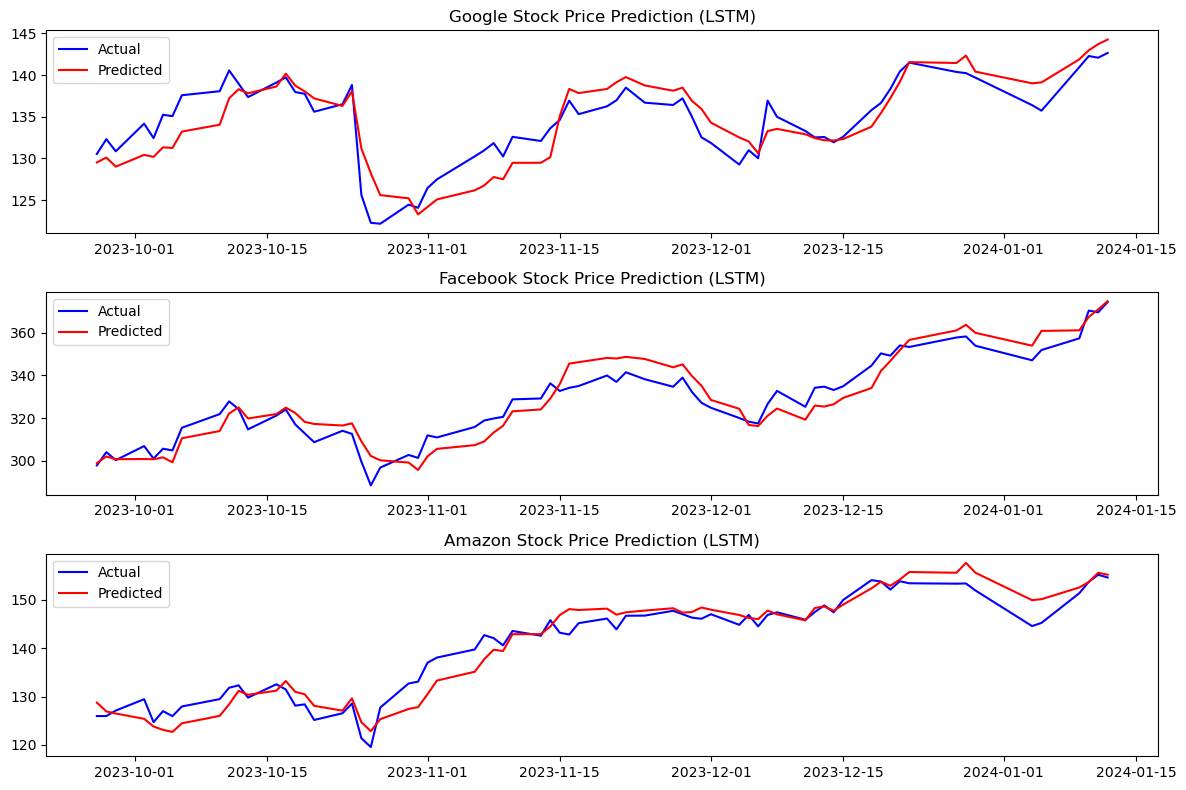

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,3.873349,0.986531,5.837073,0.742346
1,Facebook,43.633174,0.993201,41.730548,0.887541
2,Amazon,9.940336,0.987860,7.265274,0.927587


In [8]:
def create_and_evaluate_lstm_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Normalize the data
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    target = scaler.fit_transform(target.values.reshape(-1, 1))

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Reshape data for LSTM
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Create an LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

    # Model training
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Inverse transform to get original scale
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate LSTM models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_lstm_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_lstm_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_lstm_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))


# Google
plt.subplot(3, 1, 1)
plt.plot(data.index[-len(google_y_test):], google_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(google_y_test):], google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (LSTM)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index[-len(facebook_y_test):], facebook_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(facebook_y_test):], facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (LSTM)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index[-len(amazon_y_test):], amazon_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(amazon_y_test):], amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

results_df


# Online Models (River)

## LinearRegression

Best hyperparameters for Google: {'grace_period': None, 'model_selector_decay': None, 'max_depth': None, 'intercept_lr': 0.1, 'optimizer': SGD({'lr': Constant({'learning_rate': 0.01}), 'n_iterations': 2058})}
Best MSE for Google: 48.458206880012256


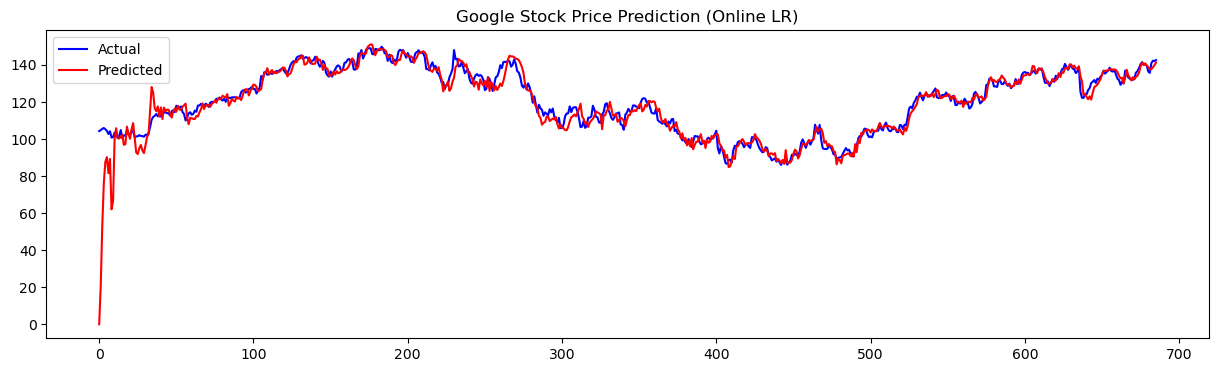

Best hyperparameters for Facebook: {'grace_period': None, 'model_selector_decay': None, 'max_depth': None, 'intercept_lr': 0.1, 'optimizer': SGD({'lr': Constant({'learning_rate': 0.01}), 'n_iterations': 4802})}
Best MSE for Facebook: 342.8090614206243


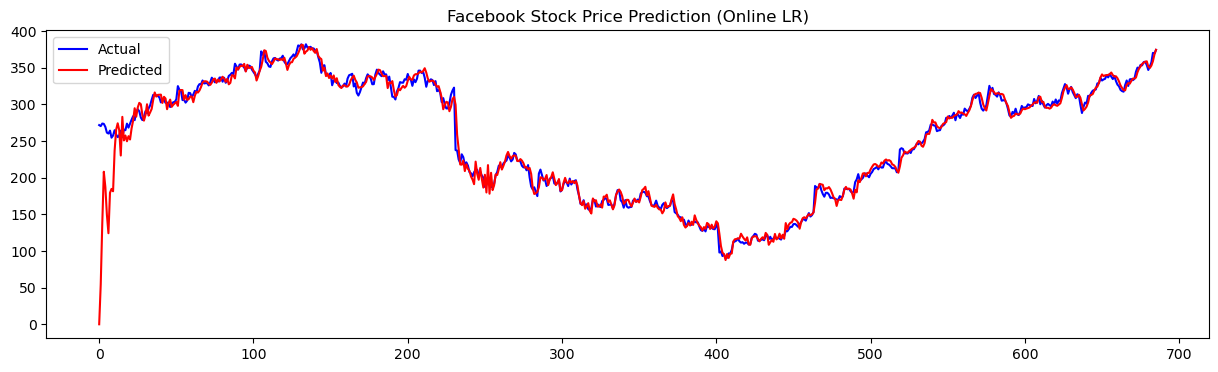

Best hyperparameters for Amazon: {'grace_period': None, 'model_selector_decay': None, 'max_depth': None, 'intercept_lr': 0.1, 'optimizer': SGD({'lr': Constant({'learning_rate': 0.01}), 'n_iterations': 7546})}
Best MSE for Amazon: 122.5372955883933


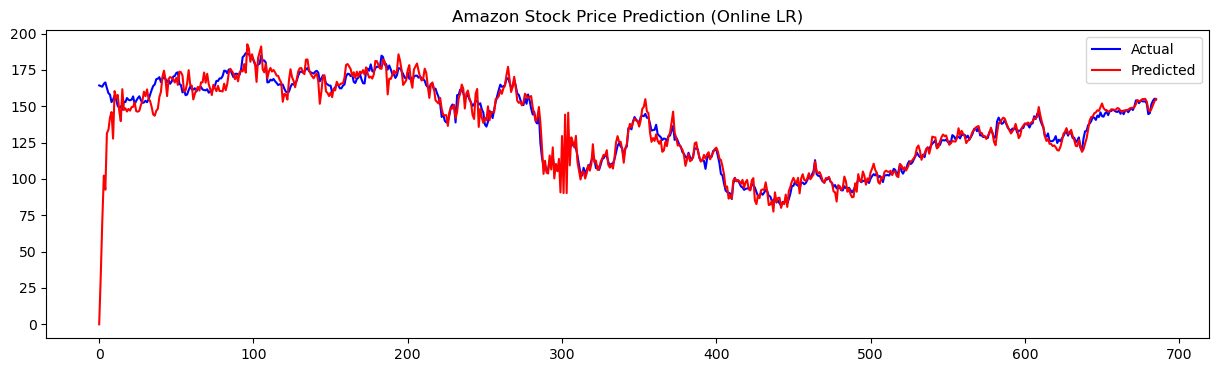

,Google,Facebook,Amazon
MSE,48.458207,342.809061,122.537296
MA,3.099315,6.846627,4.636382
R^2,0.828998,0.946432,0.836082


In [43]:
from river import optim

def create_and_evaluate_online_model(stock_name, data, intercept_lr, optimizer):

    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (preprocessing.StandardScaler() | 
            linear_model.LinearRegression(
                intercept_lr=intercept_lr,
                optimizer=optimizer
            )
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'intercept_lr': [0.1, 0.01, 0.001],
    'optimizer': [optim.SGD(0.01), optim.Adam(0.01), optim.RMSProp(0.01)],
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'grace_period': None, 'model_selector_decay': None, 'max_depth': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for intercept_lr in param_grid['intercept_lr']:
        for optimizer in param_grid['optimizer']:
            predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, intercept_lr, optimizer)

            # Update best hyperparameters if the current configuration has lower MSE
            if mse < best_mse:
                best_mse = mse
                best_hyperparams['intercept_lr'] = intercept_lr
                best_hyperparams['optimizer'] = optimizer

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['intercept_lr'], best_hyperparams['optimizer'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online LR)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_LR = pd.DataFrame(results)
results_df_online_LR

## HoeffdingTreeRegressor

Best hyperparameters for Google: {'grace_period': 100, 'model_selector_decay': 0.5, 'max_depth': 5}
Best MSE for Google: 126.165430206641


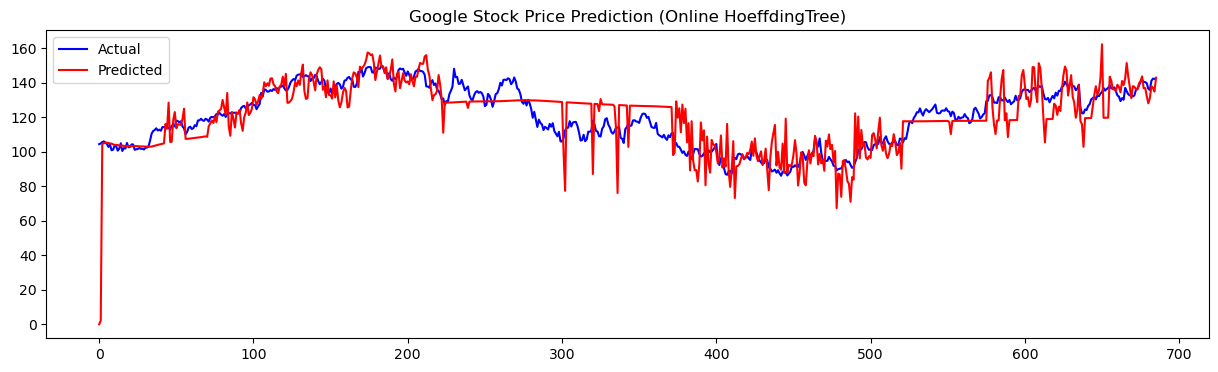

Best hyperparameters for Facebook: {'grace_period': 100, 'model_selector_decay': 0.5, 'max_depth': 5}
Best MSE for Facebook: 1010.859522611999


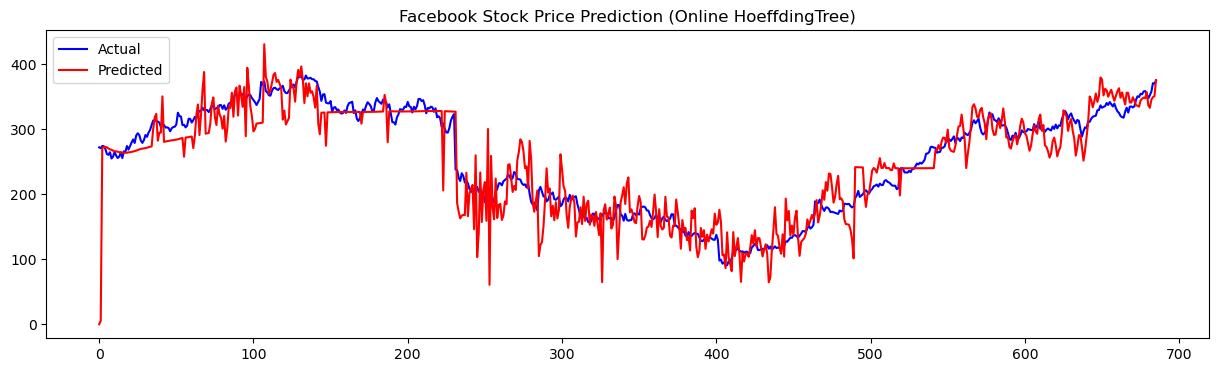

Best hyperparameters for Amazon: {'grace_period': 300, 'model_selector_decay': 0.5, 'max_depth': 5}
Best MSE for Amazon: 261.1894821312919


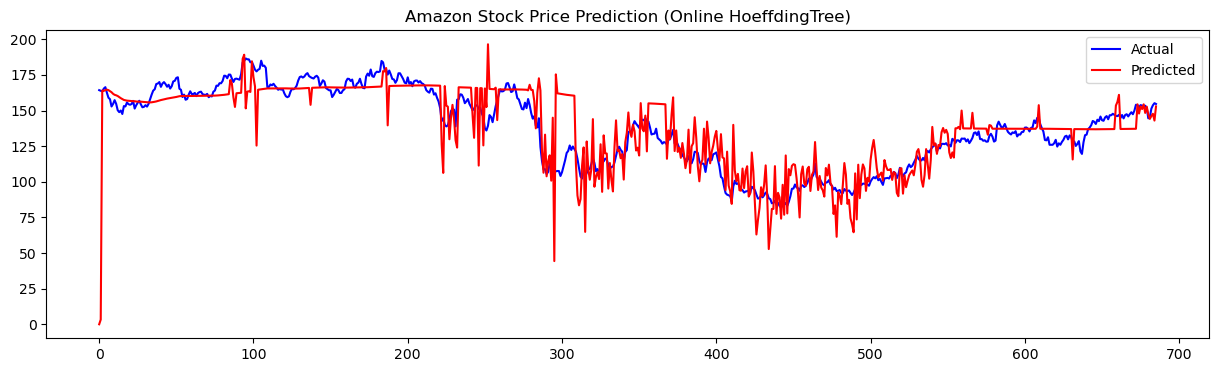

,Google,Facebook,Amazon
MSE,126.165430,1010.859523,261.189482
MA,7.877950,22.037019,9.945698
R^2,0.554781,0.842040,0.650606


In [41]:
def create_and_evaluate_online_model(stock_name, data, grace_period, model_selector_decay, max_depth):
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (
        preprocessing.StandardScaler() |
        tree.HoeffdingTreeRegressor(
            grace_period=grace_period,
            model_selector_decay=model_selector_decay,
            max_depth=max_depth)
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'grace_period': [100, 200, 300],
    'model_selector_decay': [0.5, 0.6, 0.7],
    'max_depth': [5, 10, 15]
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'grace_period': None, 'model_selector_decay': None, 'max_depth': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for grace_period in param_grid['grace_period']:
        for model_selector_decay in param_grid['model_selector_decay']:
            for max_depth in param_grid['max_depth']:
                predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, grace_period, model_selector_decay, max_depth)

                # Update best hyperparameters if the current configuration has lower MSE
                if mse < best_mse:
                    best_mse = mse
                    best_hyperparams['model_selector_decay'] = model_selector_decay
                    best_hyperparams['grace_period'] = grace_period
                    best_hyperparams['max_depth'] = max_depth

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['grace_period'], best_hyperparams['model_selector_decay'], best_hyperparams['max_depth'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online HoeffdingTree)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_HTR = pd.DataFrame(results)
results_df_online_HTR


## ARFRegressor

Best hyperparameters for Google: {'n_models': 10, 'grace_period': 10}
Best MSE for Google: 89.69233211244456


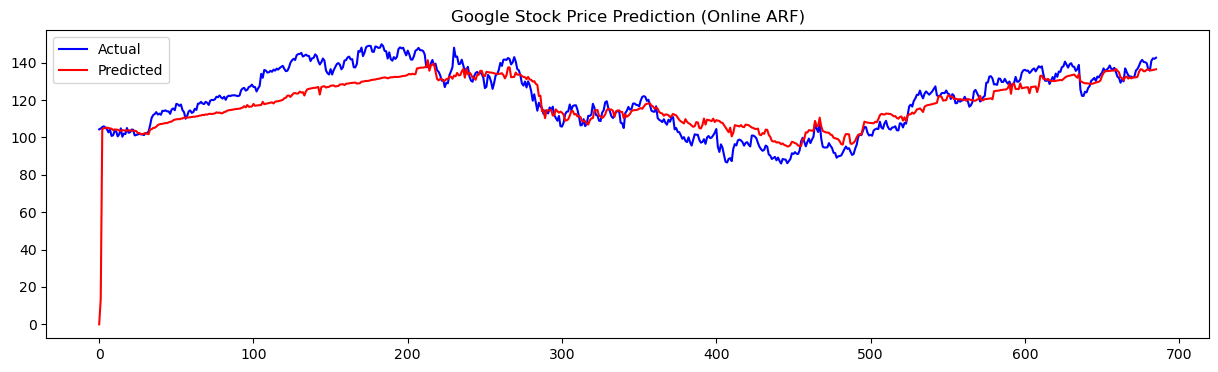

Best hyperparameters for Facebook: {'n_models': 10, 'grace_period': 50}
Best MSE for Facebook: 1084.546200603112


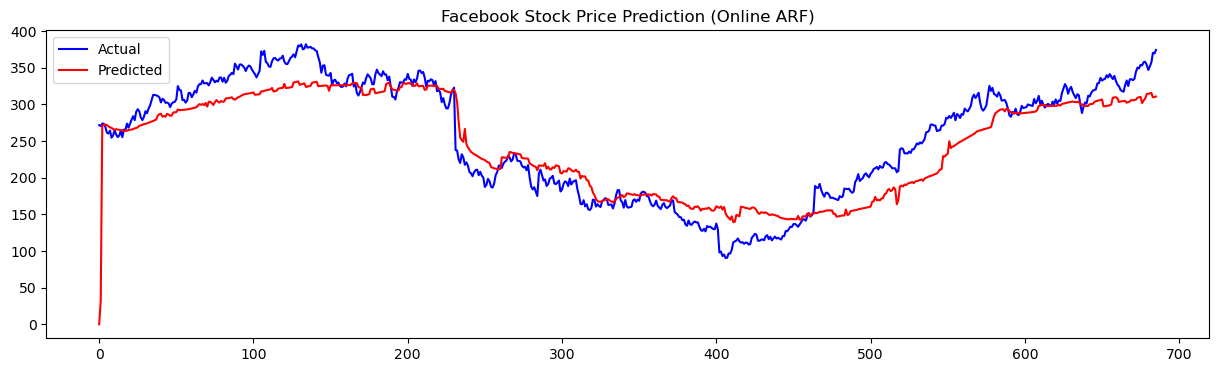

Best hyperparameters for Amazon: {'n_models': 50, 'grace_period': 50}
Best MSE for Amazon: 175.3420529447502


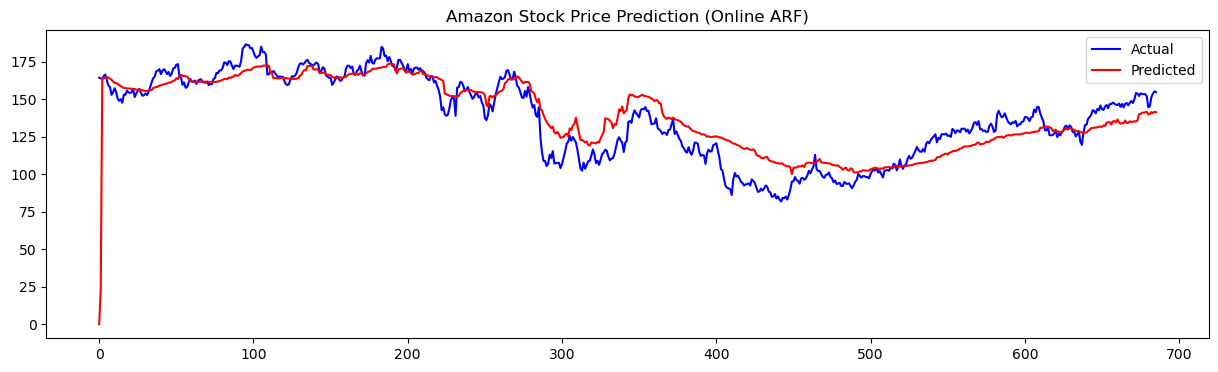

,Google,Facebook,Amazon
MSE,92.103889,1034.932221,194.887116
MA,6.678800,24.860627,9.439475
R^2,0.674979,0.838278,0.739299


In [40]:
def create_and_evaluate_online_model(stock_name, data, n_models, grace_period):
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (
        preprocessing.StandardScaler() |
        forest.ARFRegressor(n_models=n_models, grace_period=grace_period)
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'n_models': [10, 50, 100],
    'grace_period': [10, 50, 100]
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'n_models': None, 'grace_period': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for n_models in param_grid['n_models']:
        for grace_period in param_grid['grace_period']:
            predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, n_models, grace_period)

            # Update best hyperparameters if the current configuration has lower MSE
            if mse < best_mse:
                best_mse = mse
                best_hyperparams['n_models'] = n_models
                best_hyperparams['grace_period'] = grace_period

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['n_models'], best_hyperparams['grace_period'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online ARF)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_AFR = pd.DataFrame(results)
results_df_online_AFR

## KNNRegressor

Best hyperparameters for Google: {'n_neighbors': 5, 'window_size': 20}
Best MSE for Google: 24.34073268939423


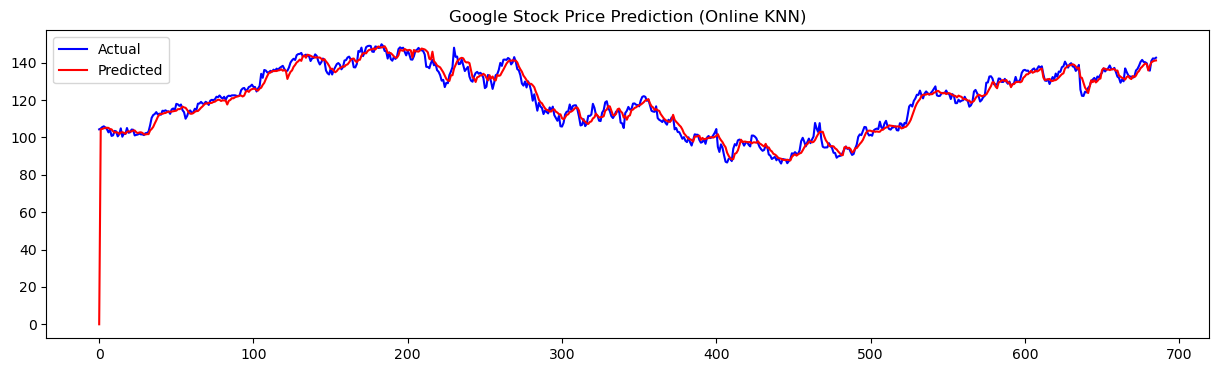

Best hyperparameters for Facebook: {'n_neighbors': 5, 'window_size': 10}
Best MSE for Facebook: 192.8911529292811


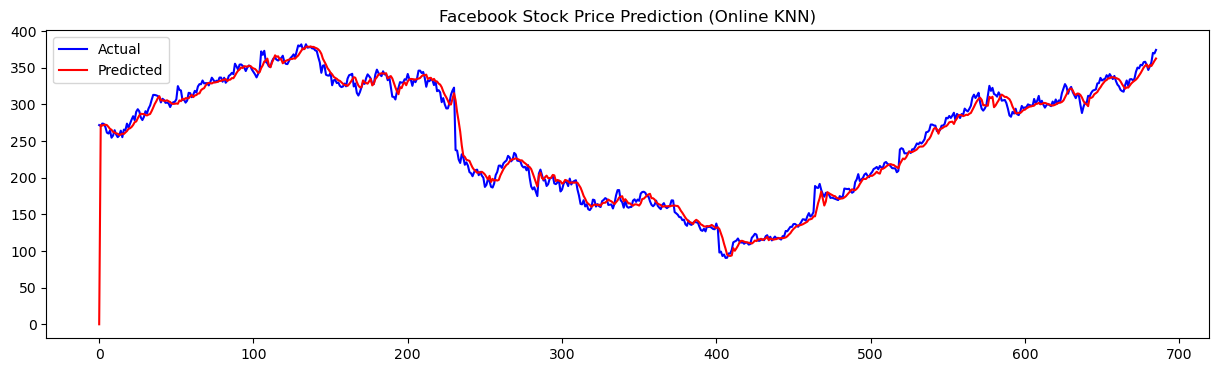

Best hyperparameters for Amazon: {'n_neighbors': 5, 'window_size': 100}
Best MSE for Amazon: 58.81375669098202


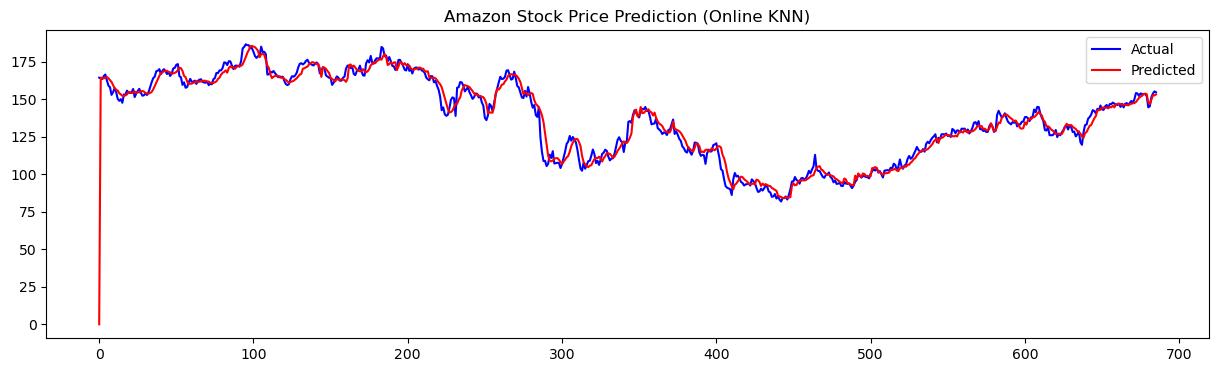

,Google,Facebook,Amazon
MSE,24.340733,192.891153,58.813757
MA,2.400057,6.988754,3.433116
R^2,0.914105,0.969858,0.921325


In [39]:
def create_and_evaluate_online_model(stock_name, data, n_neighbors, window_size):
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (
        preprocessing.StandardScaler() |
        KNNRegressor(n_neighbors=n_neighbors, window_size=window_size)
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [5, 10, 15],
    'window_size': [5, 10, 20, 50, 100]
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'n_neighbors': None, 'window_size': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for n_neighbors in param_grid['n_neighbors']:
        for window_size in param_grid['window_size']:
            predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, n_neighbors, window_size)

            # Update best hyperparameters if the current configuration has lower MSE
            if mse < best_mse:
                best_mse = mse
                best_hyperparams['n_neighbors'] = n_neighbors
                best_hyperparams['window_size'] = window_size

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['n_neighbors'], best_hyperparams['window_size'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online KNN)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_KNN = pd.DataFrame(results)
results_df_online_KNN